# Emukit animation

In [1]:
# Convenient jupyter setup
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

In [2]:
# set up plotting settings for dark mode.
from jupyterthemes import jtplot
jtplot.style(theme="grade3", context="notebook", ticks=True, grid=False)
from src.plot_utils import ps_defaults
ps_defaults(use_tex=False, dpi=150)

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import GPy
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper
from emukit.experimental_design import ExperimentalDesignLoop
from emukit.core.initial_designs.latin_design import LatinDesign
from emukit.experimental_design.experimental_design_loop import ExperimentalDesignLoop
from emukit.model_wrappers import SimpleGaussianProcessModel
from emukit.core import ParameterSpace, ContinuousParameter
from emukit.experimental_design.acquisitions import ModelVariance

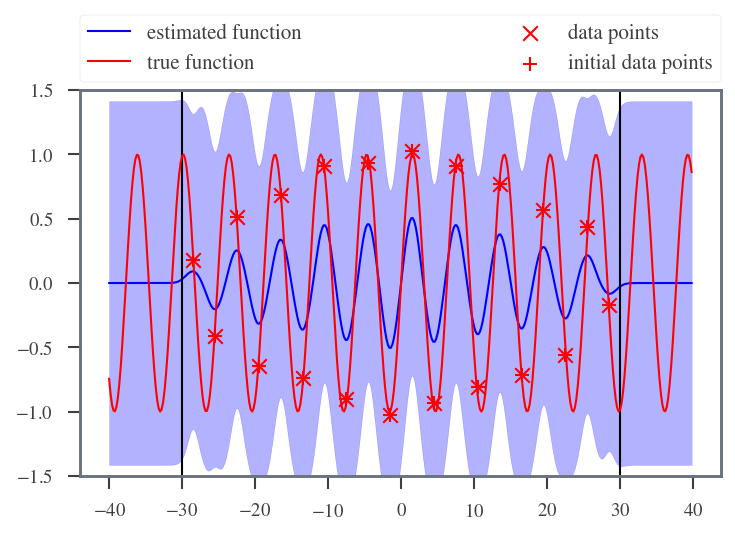

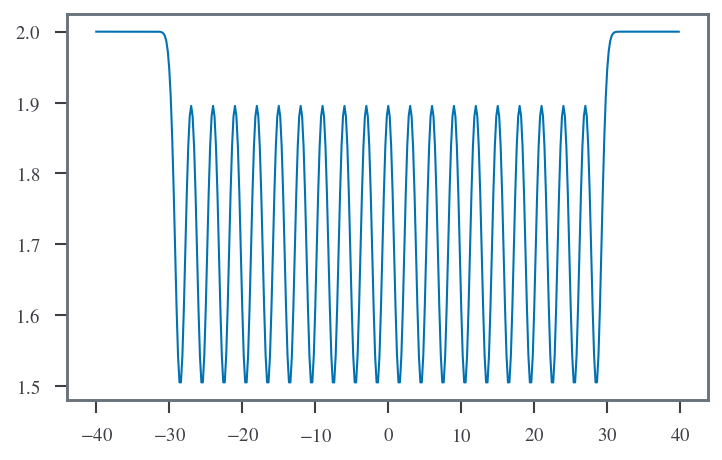

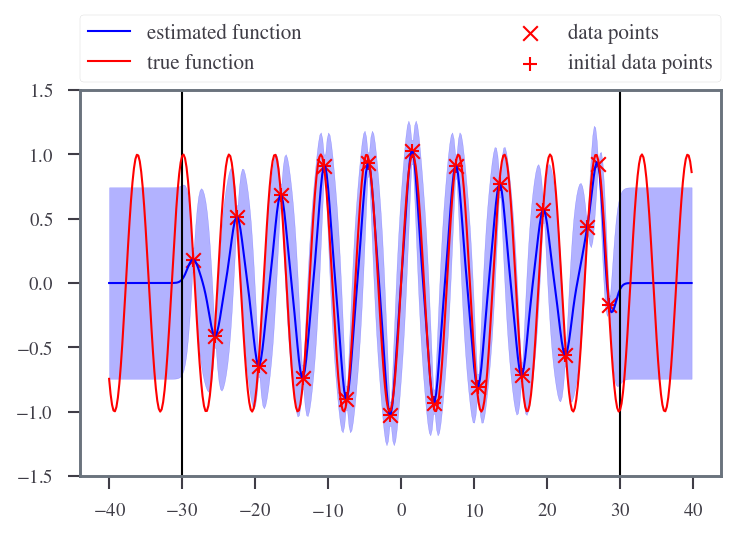

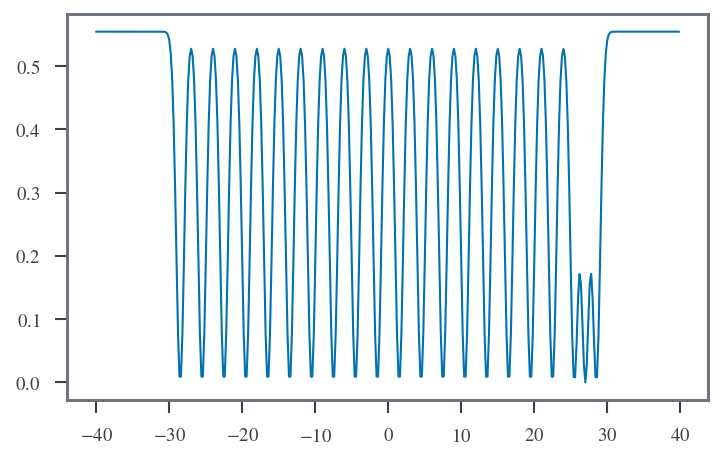

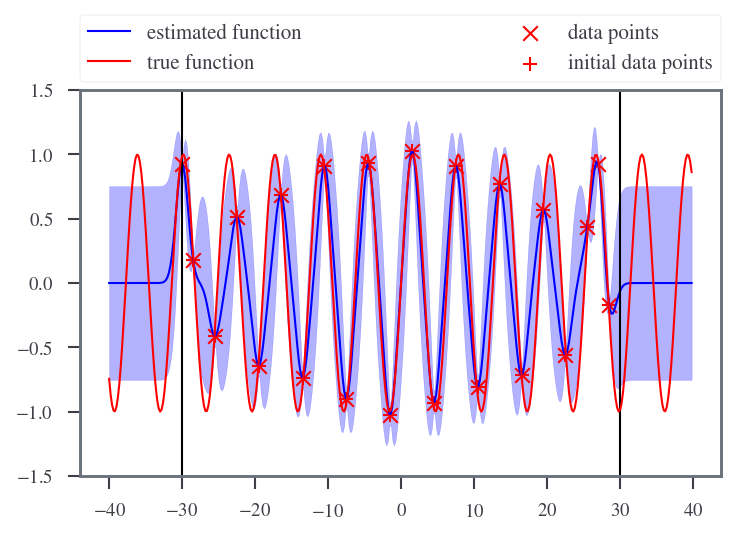

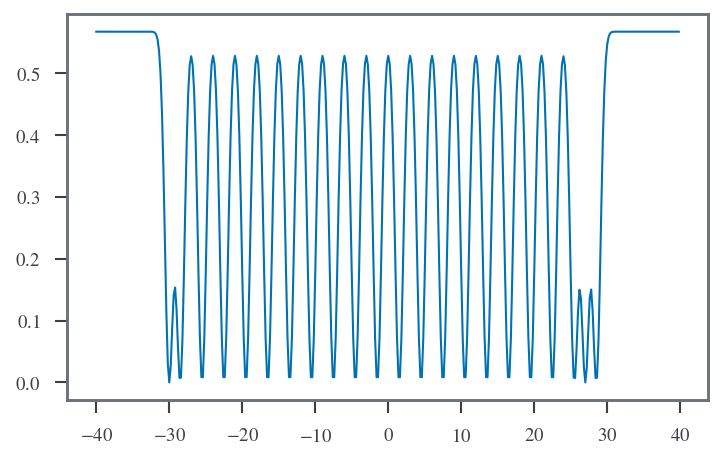

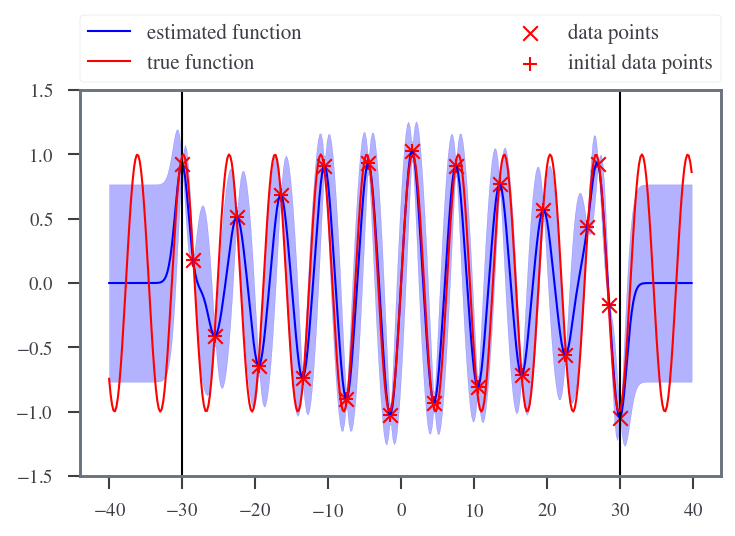

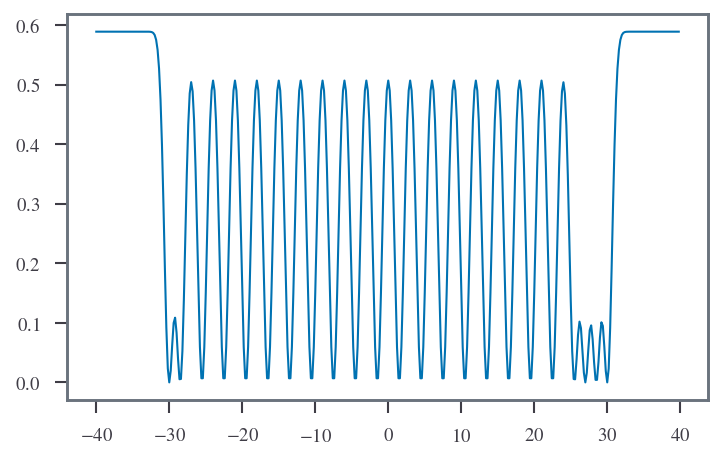

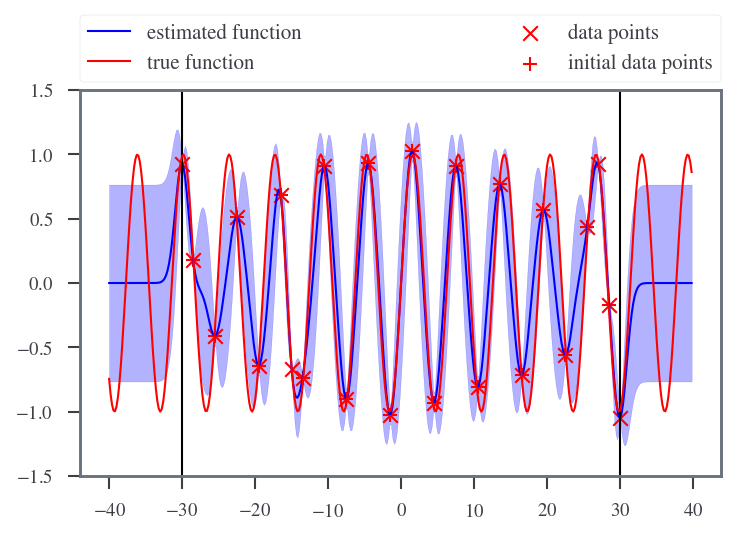

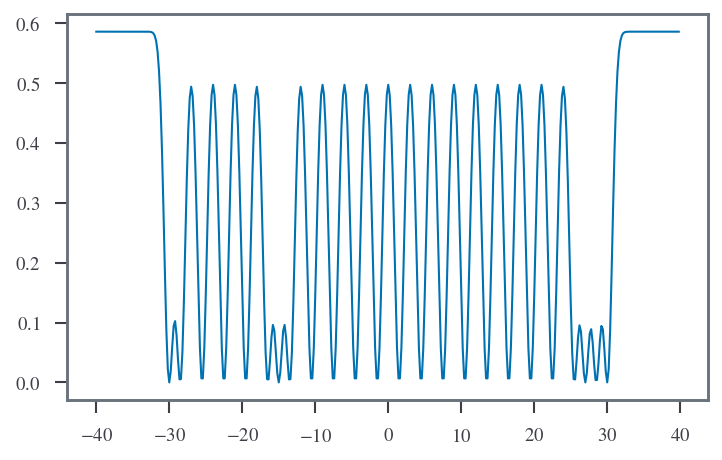

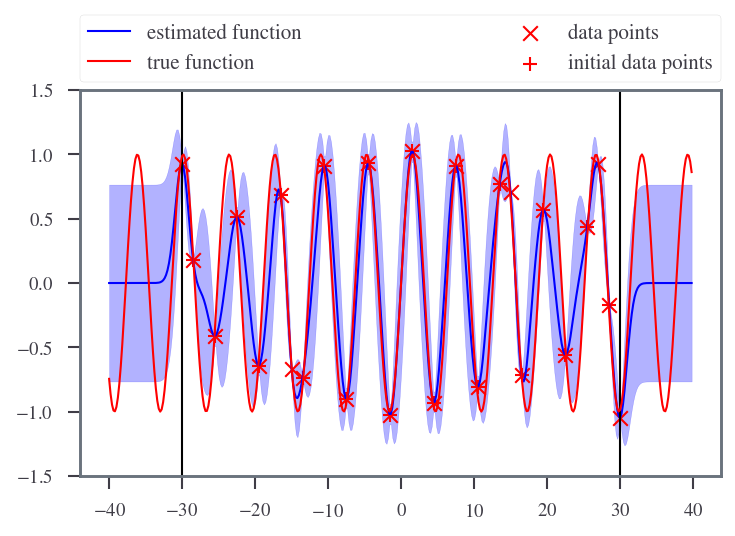

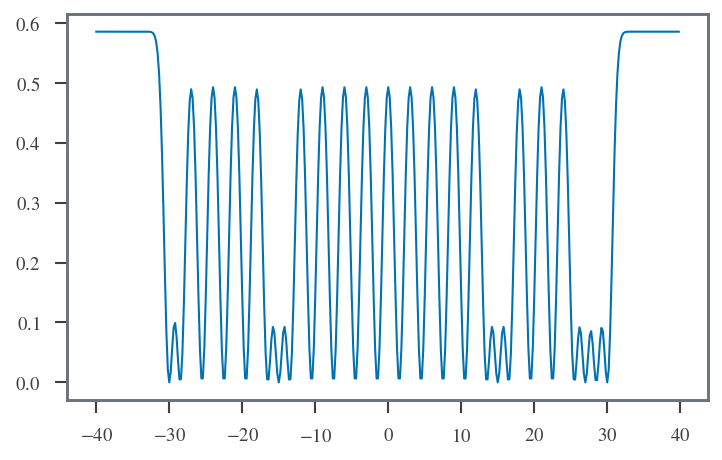

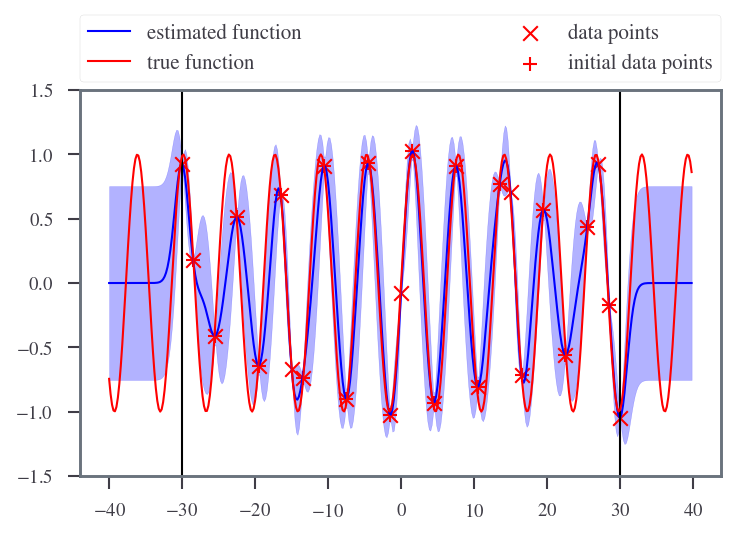

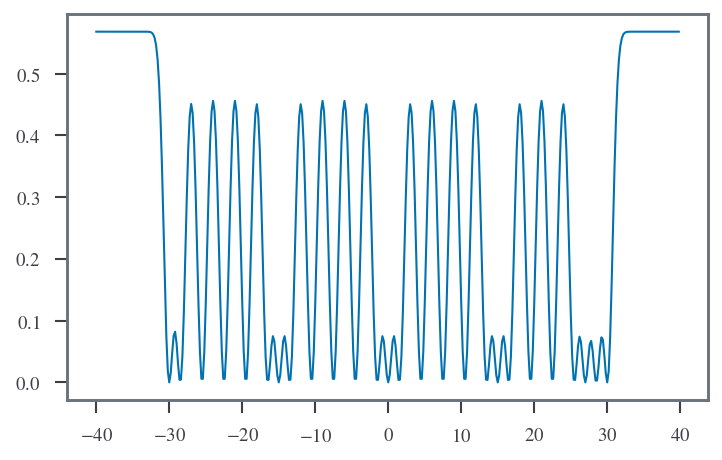

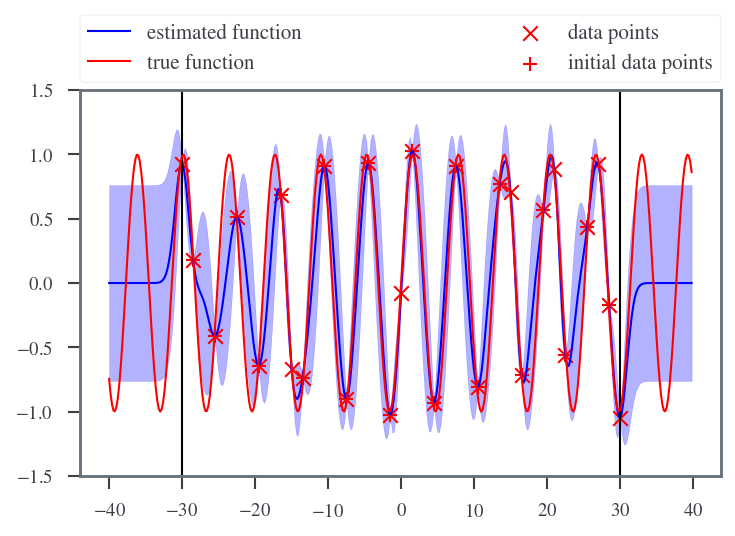

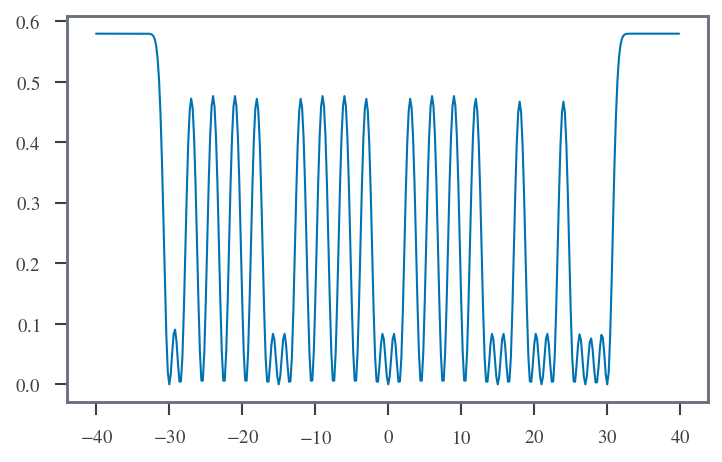

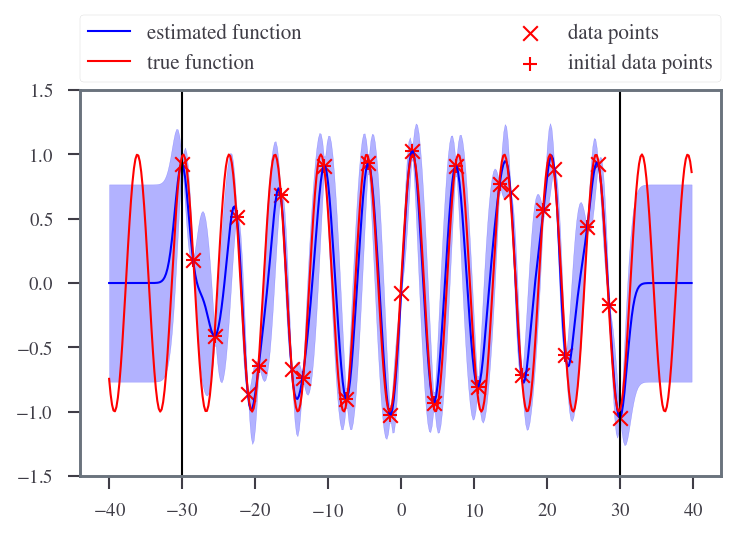

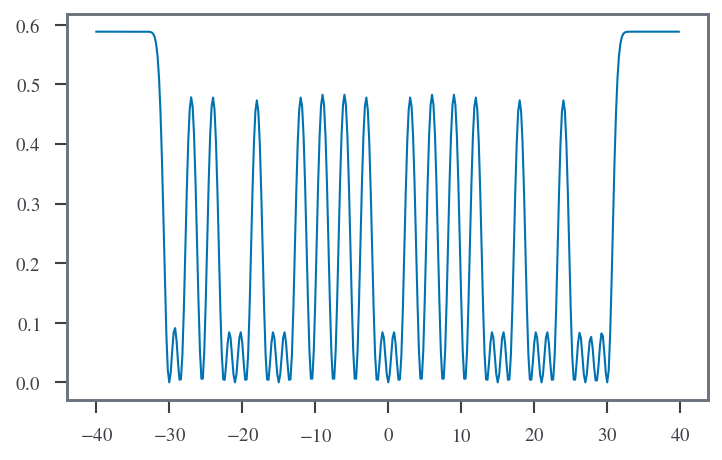

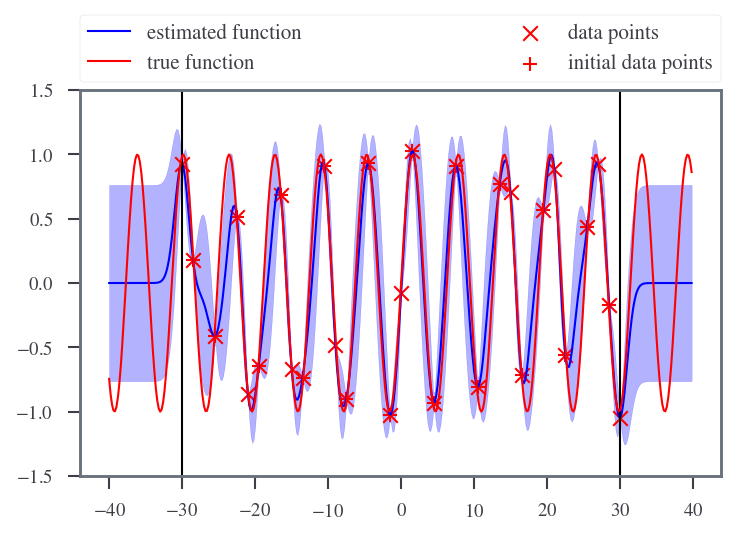

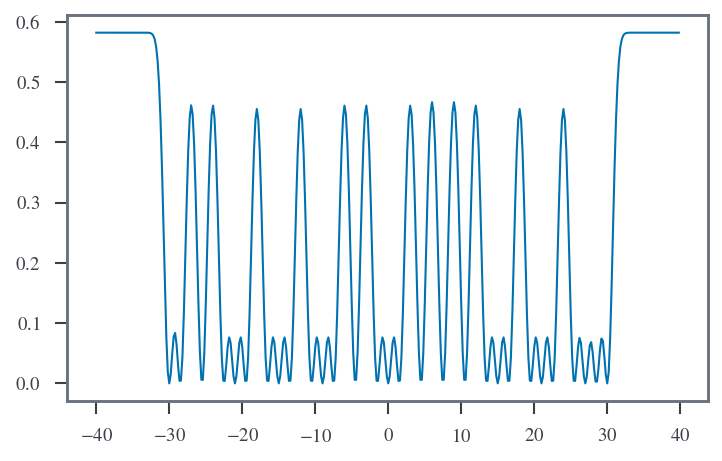

In [56]:
def func(x_inputs):
    return np.sin(x_inputs) + np.random.randn(len(x_inputs), 1) * 0.05

x_min = -30.0
x_max = 30.0
y_min = -1.50
y_max = - y_min

p = ContinuousParameter('c', x_min, x_max)
space = ParameterSpace([p])
design = LatinDesign(space) 
num_init_data_points = 20
x_data = design.get_samples(num_init_data_points)
y_data = func(x_data)

model_gpy = GPRegression(x_data, y_data)
model_emukit = GPyModelWrapper(model_gpy)
model_variance = ModelVariance(model=model_emukit)
expdesign_loop = ExperimentalDesignLoop(
    model=model_emukit, space=space, 
    acquisition=model_variance, batch_size=1
)

for i in range(10):
    plot_min = -40.0
    plot_max = 40.0
    real_x = np.arange(plot_min, plot_max, 0.2)
    real_y = np.sin(real_x)

    predicted_y = []
    predicted_std = []
    for x in real_x:
        y, var = model_emukit.predict(np.array([[x]]))
        std = np.sqrt(var)
        predicted_y.append(y)
        predicted_std.append(std)

    predicted_y = np.array(predicted_y).flatten()
    predicted_std = np.array(predicted_std).flatten()
    plt.plot(real_x, predicted_y, label="estimated function", color="blue")
    plt.fill_between(
        real_x,
        predicted_y - predicted_std,
        predicted_y + predicted_std,
        color="blue",
        alpha=0.3,
    )
    plt.scatter(expdesign_loop.loop_state.X,
                expdesign_loop.loop_state.Y, 
                c="red", 
                label="data points")
    plt.scatter(x_data,
                y_data, 
                c="red", 
                marker="+",
                label="initial data points")
    plt.plot([x_min, x_min], [y_min, y_max], color="black")
    plt.plot([x_max, x_max], [y_min, y_max], color="black")

    plt.plot(real_x, real_y, label="true function", color="red")
    plt.ylim([y_min, y_max])
    plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2)
    var = model_variance.evaluate(real_x.reshape(len(real_x), 1))
    plt.show()
    var = model_variance.evaluate(real_x.reshape(len(real_x), 1))
    plt.plot(real_x, var)
    plt.show()
    expdesign_loop.run_loop(func, 1)